# Stereo Matching with Pytorch

## **Part 2: Learning based stereo matching**
    
Before we step into training the model, you can use this nodebook to check the implementaion of your MCNET and ExtendNet in `part2a_network.py` and `gen_patch()` in `part2b_patch.py` are correct. You can also use the visualization to get a better sense of what is a positive patch and what is a negative patch.

In [1]:
# import torch and set tensor type
import torch
%matplotlib inline
import matplotlib.pyplot as plt

use_cuda = True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
tensor_type = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
torch.set_default_tensor_type(tensor_type)

torch.backends.cudnn.deterministic = True
torch.manual_seed(333) # do not change this, this is to ensure your result is reproduciable

## Network Architecture

Implement **MCNET** network architecture in `part2a_network.py` as described in the paper. We will follow the description of the accurate network for Middlebury dataset, see proj4 pdf for the network diagram. 

In [2]:
from torch import nn
from proj4_code.utils import save_model, load_model
from proj4_code.part2a_network import MCNET
from proj4_unit_tests.test_part2a_network import test_mcnet
from proj4_code.utils import verify

In [3]:
######################################################################
# This block will act as a unit test for your MCNET architecture. There are 2 tests here
# 1) test that your network output the correct size
# 2) test that you can load up a pre-trained network with the correct architecture. 
# Make sure you are able to run it without any error. 

net_tr = MCNET(ws=11,load_path = None,strict=True, use_cuda=use_cuda)
print(net_tr)
print('Testing for MCNET:', verify(test_mcnet))

MCNET(
  (conv): Sequential(
    (0): Conv2d(1, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=27104, out_features=384, bias=True)
    (1): ReLU()
    (2): Linear(in_features=384, out_features=384, bias=True)
    (3): ReLU()
    (4): Linear(in_features=384, out_features=1, bias=True)
    (5): Sigmoid()
  )
  (criterion): BCELoss()
)
Testing for MCNET: "Correct"


## Data preparation

The data from the middlebury dataset is processed to provide pixel level disparity, and the position (height, width) that the disparity occurs at in the image.

However, for the MC-CNN, we need to extract patches around the disparity. This is where the `gen_patch` function comes in.

The `gen_patch` function is used to generate patches of a given window size given the corrdinates of the top-left corner of the patch. This will later be used in the training of the MC-CNN, where we'll extract patches on the fly. 

Implement `gen_patch()` in `part2b_patch.py`

In [4]:
from proj4_code.part2b_patch import gen_patch

In [5]:
######################################################################
# This block will act as a unit test for your gen_patch function. 
from proj4_code.utils import verify
from proj4_unit_tests.test_part2b_patch import test_gen_patch

print('Testing for gen_patch:', verify(test_gen_patch))

Testing for gen_patch: "Correct"


You can use the cell below to have a better sense of how a positive and negative patch should look like, and the effect of varying the window size 

In [6]:
from proj4_code.dataset import loadbin, DataLoader
import numpy as np
import os
import random

data_dir = '../data/Adirondack'

# the img to show
ind_img = "Adirondack"
test_idx = [ind_img]

ValData = DataLoader(data_dir, test_idx)

Left Image


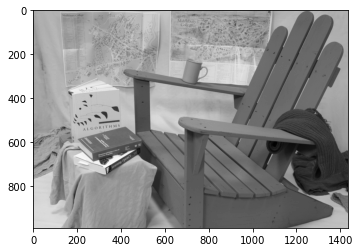

Right Image


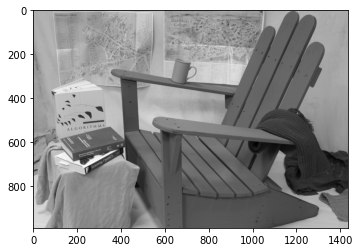

In [7]:
# visualize the test data
print('Left Image')
plt.imshow(ValData.imgs_left[ind_img][0].cpu().numpy(),cmap="gray")
plt.show()
print('Right Image')
plt.imshow(ValData.imgs_right[ind_img][0].cpu().numpy(),cmap="gray")
plt.show()
# print('Ground Truth disparity')
# plt.imshow(ValData.disps[ind_img], cmap='jet')
# plt.show()

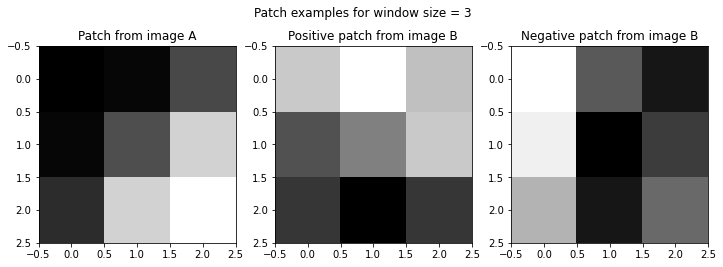

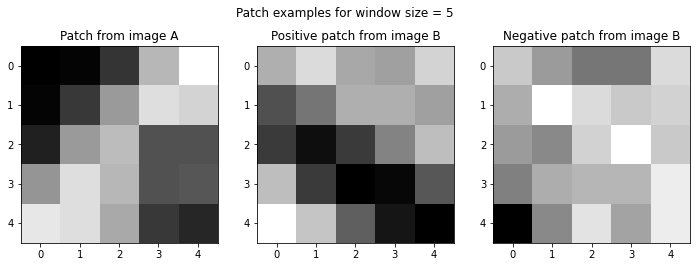

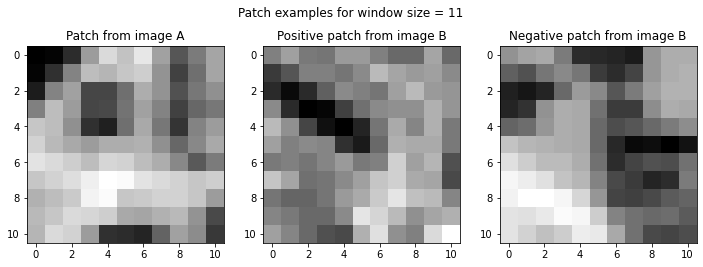

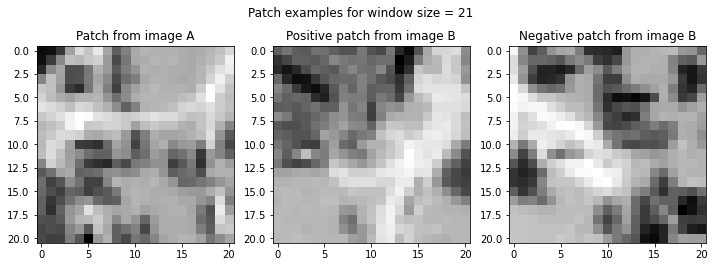

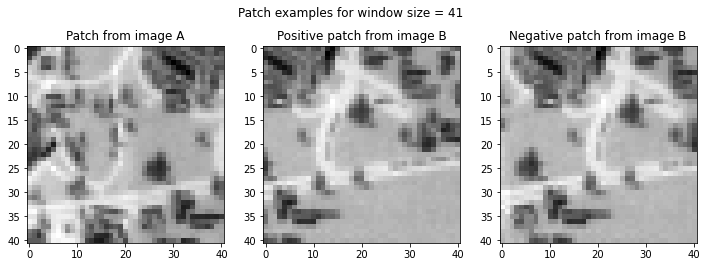

In [8]:
import math
import torch

def visualize_patch(ind_img: str, row: int, col: int, d: int, ws: int):
    d_pos = 0
    d_neg = np.random.randint(5,25)

    if np.random.rand(1) < 0.5:
        d_neg = -d_neg

    x0 = ValData.imgs_left[ind_img]
    x1 = ValData.imgs_right[ind_img]

    anchor = gen_patch(x0, row, col, ws)
    pos = gen_patch(x1, row, col - d + d_pos, ws)
    neg = gen_patch(x1, row, col - d + d_neg, ws)

    fig = plt.figure(figsize=(12,4))

    plt.subplot(1, 3, 1)
    plt.imshow(anchor[0].cpu().numpy(),cmap='gray')
    plt.title('Patch from image A')

    plt.subplot(1, 3, 2)
    plt.imshow(pos[0].cpu().numpy(),cmap='gray')
    plt.title('Positive patch from image B')

    plt.subplot(1, 3, 3)
    plt.imshow(neg[0].cpu().numpy(),cmap='gray')
    plt.title('Negative patch from image B')

    fig.suptitle('Patch examples for window size = {}'.format(ws))
    plt.show()

row = 200
col = 400
d = ValData.disps[ind_img][row][col].astype(int)
window_sizes = [3, 5, 11, 21, 41]

for ws in window_sizes:
    visualize_patch(ind_img, row, col, d, ws)

# Testing Disparity Calculation

In [9]:
from proj4_unit_tests.test_part2c_disparity import (
    test_calculate_mccnn_disparity_map,
    test_calculate_mccnn_cost_volume,
    test_calculate_mccnn_cost_volume_argmin
)
print('Testing for disparity map:', verify(test_calculate_mccnn_disparity_map))

print('Testing for cost volume:', verify(test_calculate_mccnn_disparity_map))

print('Testing for cost volume\'s argmin:', verify(test_calculate_mccnn_disparity_map))

shape '[1, 1, 7, 7]' is invalid for input of size 7
Testing for disparity map: "Wrong"
shape '[1, 1, 7, 7]' is invalid for input of size 7
Testing for cost volume: "Wrong"
shape '[1, 1, 7, 7]' is invalid for input of size 7
Testing for cost volume's argmin: "Wrong"


Now that you have implemented the network structure correctly, are able to extract patches from the given data, and can correctly calculate the disparity map, you can go ahead and work on `part2_mc_cnn.ipynb` on Google Colab.